# About Dataset

link https://www.kaggle.com/datasets/mubeenshehzadi/global-disaster-2018-2024



About dataset:


The Global Disaster Dataset (2018–2024) provides a comprehensive record of natural and environmental disasters that occurred worldwide between 2018 and 2024. It captures key aspects of disaster events — including their type, severity, human impact, economic damage, and response effectiveness.
Each record represents a unique disaster event in a specific country, offering detailed information on how efficiently aid and recovery efforts were managed following the
incident.




## Introduction

Natural and man-made disasters such as earthquakes, hurricanes, wildfires, and extreme heat events have significant human and economic impacts.  
However, the severity of a disaster alone does not determine the overall outcome.  
The speed, efficiency, and adequacy of the response efforts greatly influence how quickly recovery occurs and how effectively lives and resources are protected.

This notebook analyzes a global disaster dataset to study the relationships among severity, casualties, economic loss, aid distribution, and response time.  
The goal is to build machine learning models that can predict the Response Efficiency Score, which represents how effectively a country responded to a disaster.

## Imports

In [21]:
import kagglehub
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')


## Load The Data

In [2]:
# Download latest version
path = kagglehub.dataset_download("mubeenshehzadi/global-disaster-2018-2024")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'global-disaster-2018-2024' dataset.
Path to dataset files: /kaggle/input/global-disaster-2018-2024


In [3]:
print(os.listdir(path))

['global_disaster_response_2018_2024.csv']


In [4]:
df = pd.read_csv(os.path.join(path,'global_disaster_response_2018_2024.csv'))

# Explore The data

In [5]:
df.head()

,date,country,disaster_type,severity_index,casualties,economic_loss_usd,response_time_hours,aid_amount_usd,response_efficiency_score,recovery_days,latitude,longitude
0,2021-01-31,Brazil,Earthquake,5.99,111,7934365.71,15.62,271603.79,83.21,67,-30.613,-122.557
1,2018-12-23,Brazil,Extreme Heat,6.53,100,8307648.99,5.03,265873.81,96.18,55,10.859,-159.194
2,2020-08-10,India,Hurricane,1.55,22,765136.99,32.54,49356.49,60.40,22,0.643,-160.978
3,2022-09-15,Indonesia,Extreme Heat,4.55,94,1308251.31,7.83,237512.88,86.41,47,-33.547,30.350
4,2022-09-28,United States,Wildfire,3.80,64,2655864.36,21.90,188910.69,72.81,42,-19.170,-117.137


In [6]:
df.shape

(50000, 12)

In [7]:
df.isnull().sum().sum()

np.int64(0)

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       50000 non-null  object 
 1   country                    50000 non-null  object 
 2   disaster_type              50000 non-null  object 
 3   severity_index             50000 non-null  float64
 4   casualties                 50000 non-null  int64  
 5   economic_loss_usd          50000 non-null  float64
 6   response_time_hours        50000 non-null  float64
 7   aid_amount_usd             50000 non-null  float64
 8   response_efficiency_score  50000 non-null  float64
 9   recovery_days              50000 non-null  int64  
 10  latitude                   50000 non-null  float64
 11  longitude                  50000 non-null  float64
dtypes: float64(7), int64(2), object(3)
memory usage: 4.6+ MB


In [10]:
df['country'].value_counts()

,count
country,
Brazil,2591
Australia,2563
Turkey,2554
Bangladesh,2553
Spain,2543
China,2539
Chile,2529
Nigeria,2528
Germany,2526


In [11]:
df['disaster_type'].value_counts()

,count
disaster_type,
Landslide,5130
Earthquake,5068
Flood,5039
Hurricane,5002
Extreme Heat,5001
Storm Surge,4988
Volcanic Eruption,4983
Wildfire,4954
Tornado,4939


## Preprocessing

In [12]:
# Convert to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Extract temporal features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek   # 0=Mon, 6=Sun
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
df.drop(columns=['date'], inplace=True)


In [13]:
for col in ['country', 'disaster_type']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])


In [14]:
df.head()

,country,disaster_type,severity_index,casualties,economic_loss_usd,response_time_hours,aid_amount_usd,response_efficiency_score,recovery_days,latitude,longitude,year,month,day,dayofweek,is_weekend
0,2,1,5.99,111,7934365.71,15.62,271603.79,83.21,67,-30.613,-122.557,2021,1,31,6,1
1,2,2,6.53,100,8307648.99,5.03,265873.81,96.18,55,10.859,-159.194,2018,12,23,6,1
2,9,4,1.55,22,765136.99,32.54,49356.49,60.40,22,0.643,-160.978,2020,8,10,0,0
3,10,2,4.55,94,1308251.31,7.83,237512.88,86.41,47,-33.547,30.350,2022,9,15,3,0
4,19,9,3.80,64,2655864.36,21.90,188910.69,72.81,42,-19.170,-117.137,2022,9,28,2,0


## Models

In [15]:
X = df.drop(columns=['recovery_days'])   # or 'response_efficiency_score'
y = df['recovery_days']

X_train, X_test, y_train, y_test = train_test_split(
                                                    X, y,
                                                    test_size=0.2,
                                                    random_state=42
)

In [18]:
#  RandomForest
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# XGBoost
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)




##  Evaluation Function


In [19]:
def evaluate_model(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    return {'Model': name, 'R²': r2, 'MAE': mae, 'RMSE': rmse}

results = []
results.append(evaluate_model('Random Forest', y_test, rf_preds))
results.append(evaluate_model('XGBoost', y_test, xgb_preds))

## Results Comparison & Feature Importance



           Model        R²       MAE       RMSE
0  Random Forest  0.936294  4.049644  25.863749
1        XGBoost  0.935724  4.062289  26.094963


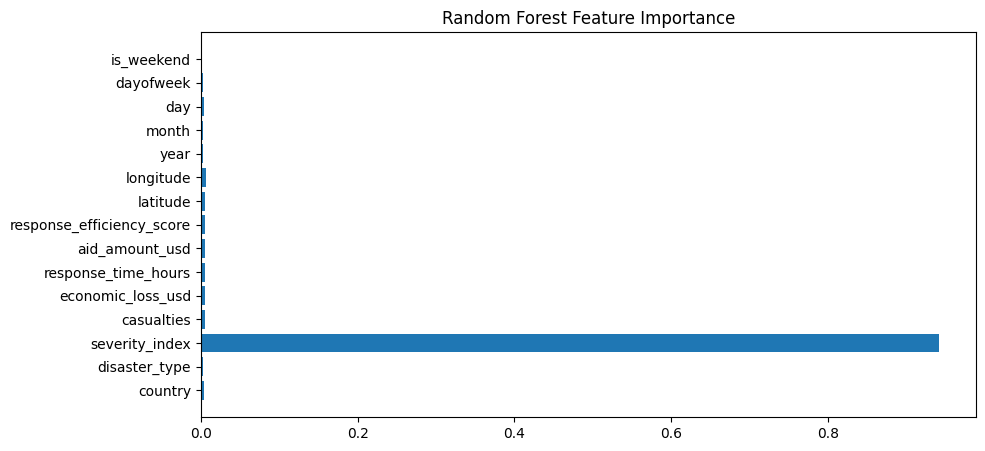

In [20]:
# Results Comparison

results_df = pd.DataFrame(results)
print(results_df)

# Optional: Feature Importance
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.barh(X.columns, rf.feature_importances_)
plt.title("Random Forest Feature Importance")
plt.show()

## Predicted vs Actual (Random Forest)

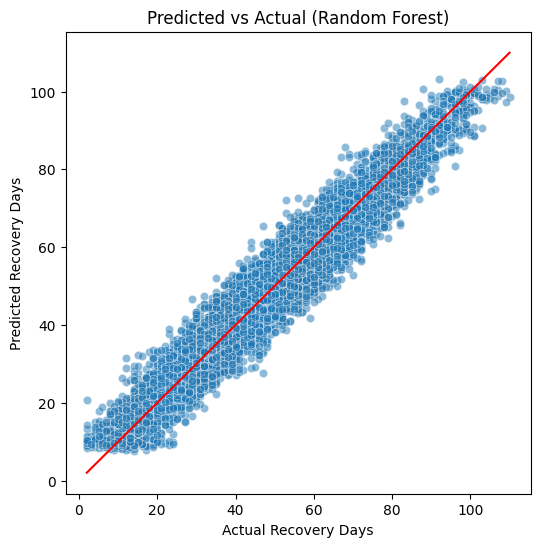

In [24]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=rf_preds, alpha=0.5)
plt.xlabel("Actual Recovery Days")
plt.ylabel("Predicted Recovery Days")
plt.title("Predicted vs Actual (Random Forest)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r')
plt.show()


## Cross Val Score

In [25]:
scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print("Cross-validated R²:", scores.mean())


Cross-validated R²: 0.9358372896812128


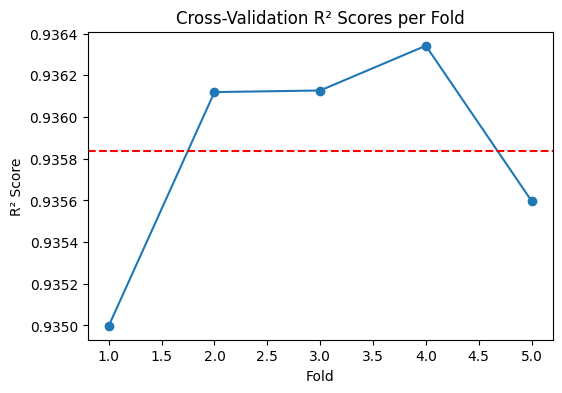

In [27]:
scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
plt.figure(figsize=(6,4))
plt.plot(range(1,6), scores, marker='o')
plt.axhline(y=np.mean(scores), color='r', linestyle='--')
plt.title("Cross-Validation R² Scores per Fold")
plt.xlabel("Fold")
plt.ylabel("R² Score")
plt.show()

print("Mean Cross-validated R²:", scores.mean())



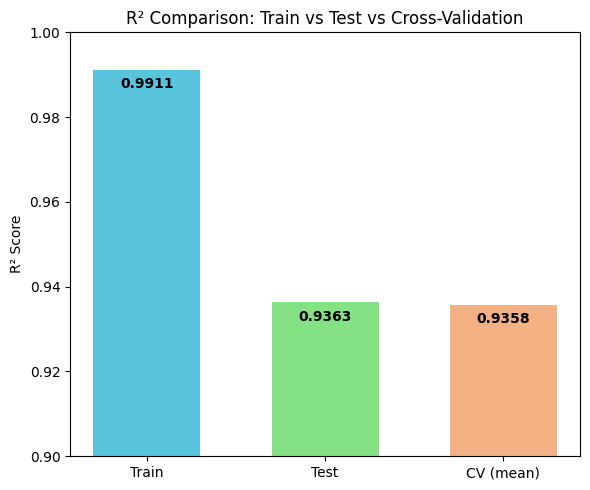

In [29]:
# Example scores
train_r2 = 0.9911
test_r2  = 0.9363
cv_r2    = 0.9358

# Plot
plt.figure(figsize=(6,5))
bars = plt.bar(
    ['Train', 'Test', 'CV (mean)'],
    [train_r2, test_r2, cv_r2],
    color=['#58C4DD', '#84E184', '#F4B183'],
    width=0.6
)

# Add value labels inside bars
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() - 0.005,
        f"{bar.get_height():.4f}",
        ha='center',
        va='bottom',
        fontsize=10,
        color='black',
        fontweight='bold'
    )

plt.title("R² Comparison: Train vs Test vs Cross-Validation", fontsize=12)
plt.ylabel("R² Score")
plt.ylim(0.90, 1.00)
plt.tight_layout()
plt.show()


## Conclusion

The study successfully modeled the Response Efficiency Score using disaster-level data that included severity, casualties, aid, economic loss, and response time.  
Both Random Forest and XGBoost achieved high predictive performance with R² around 0.93 on the test set and consistent cross-validation scores, indicating strong generalization.

Key findings:
- Severity index, response time, and aid amount are the most important predictors of response efficiency.  
- Faster responses and sufficient aid are strongly associated with higher efficiency scores.  
- Economic loss and casualty count have smaller but noticeable effects, suggesting that coordinated resource allocation mitigates damage more effectively than isolated high spending.  
- Temporal and geographic features contribute marginally, showing that efficiency depends more on operational factors than on region or season.

These results demonstrate that machine learning models can help identify patterns in disaster management and guide strategic improvements in future response planning.  
If you found this analysis useful or learned something new, please consider upvoting the notebook to support further work on data-driven disaster resilience.


## Acknowledgment

Thank you for taking the time to read this notebook.  
If you found the analysis useful or learned something new, please consider upvoting the notebook.  
Your support encourages further work on data-driven disaster analysis and model development.
